In [3]:
from pathlib import Path
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Evaluation of different allocation approaches

In [4]:
def load_evaluation_files(base_folders=None, root_path="."):
    """
    Load all .json files from the 'evaluation' subdirectories of specified folders.

    Args:
        base_folders (list): List of folders to look for (e.g., ['testset1', 'testset3', 'testset4']).
        root_path (str): The root path where the base folders are located (default is the current directory).

    Returns:
        dict: A dictionary where keys are file paths and values are the parsed JSON data.
    """
    all_data = {}
    if base_folders is None:
        base_folders = [folder.name for folder in Path(root_path).iterdir() if folder.is_dir()]
    
    print(base_folders)
    for folder in base_folders:
        eval_path = os.path.join(root_path, folder,"**",  "evaluation","**", "*.json")
        json_files = glob.glob(eval_path, recursive = True)

        for file_path in json_files:
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    all_data[str(file_path)] = {}
                    all_data[str(file_path)]["solution"] = data["solution"]
                    all_data[str(file_path)]["metadata"] = data["metadata"]
                    if "solution_combined" in data.keys():
                        all_data[str(file_path)]["solution_combined"] = data["solution_combined"]
            except Exception as e:
                del all_data[str(file_path)]
                print(f"Error loading {file_path}: {e}")
    
    
    return all_data

In [5]:
def generate_pandas_df(data):
    for file_path, values in data.items():
        solution = {file_path : values["solution"]}
        metadata = {file_path : values["metadata"]}
        if 'solution_combined' in values.keys():
            solution_combined = {file_path : values["solution_combined"]}
            solution_combined_df = pd.DataFrame.from_dict(solution_combined, orient="index")
        df = pd.DataFrame.from_dict(solution, orient="index")
        meta_df = pd.DataFrame.from_dict(metadata, orient="index")
        
        df = pd.concat([df, meta_df], axis=1)

    df = pd.DataFrame.from_dict(data, orient="index")
    solution_norm = pd.json_normalize(df["solution"]).set_index(df.index)
    metadata_norm = pd.json_normalize(df["metadata"]).set_index(df.index)

    solution_combined_df = pd.json_normalize(df["solution_combined"]).set_index(df.index)

    # combine the two normalized dfs
    df_normalized = df.drop(["solution", "metadata"], axis=1)\
                    .join(solution_norm, rsuffix='_sol')\
                    .join(metadata_norm, rsuffix='_meta')
    df_normalized.reset_index(inplace=True)
    df_normalized['config_name'] = df_normalized["index"].apply(lambda x: x.split('/')[1]) + df_normalized["index"].apply(lambda x: x.split('/')[-1])
    df_normalized["solution_type"] = df_normalized["index"].apply(lambda x: x.split('/')[-2])
    df_normalized.set_index('index', inplace=True)

    return df_normalized, solution_combined_df

def pre_process_df(df:pd.DataFrame):
    df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
    
    df = df.sort_values(by=['config_name', 'objective'])

    # Calculate the absolute difference to best performing allocation: 
    df_shortened = df[['set_ident', 'solution_type', 'objective', 'release_times']]
    df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")
    
    # Get heuristic value
    heuristic_df = df_shortened[df_shortened["solution_type"] == "heuristic"][["set_ident", "objective"]]
    heuristic_df = heuristic_df.rename(columns={"objective": "heur_objective"})

    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(heuristic_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get enthropy value
    enthropy_df = df[df["solution_type"] == "single_instance_cp_sigma_shift"][["set_ident", 'tasks', "enthropy"]]
    df = df.drop(columns=["enthropy"])
    # Normalize entropy for each config_name
    enthropy_df['normalized_entropy'] = enthropy_df[['tasks', "enthropy"]].groupby('tasks')['enthropy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    enthropy_df['normalized_entropy_all'] = enthropy_df[["enthropy"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(enthropy_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get parallelity value
    parallelity_df = df[df["solution_type"] == "single_instance_cp_sigma_shift"][["set_ident", "parallelity"]]
    parallelity_df['parallelity_norm'] = parallelity_df[["parallelity"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df = df.drop(columns=["parallelity"])
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(parallelity_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)
    
    df_shortened["makespan_deviation"] = df_shortened["objective"] - df_shortened["min_objective"]
    df_shortened["deviation_to_heur"] = df_shortened["objective"] - df_shortened["heur_objective"]


    # Relative makespan deviation
    df_shortened['relative_makespan_deviation'] = df_shortened["makespan_deviation"]/ df_shortened["min_objective"]
    df_shortened['relative_makespan_deviation'] = (df_shortened['relative_makespan_deviation']*100.).round(2)
    
    df_shortened["release_type"] = df_shortened["release_times"].apply(
        lambda x: "arrival" if type(x) is float or len(set(x)) > 1 else "same_release"
    )

    df = df.join(df_shortened[['makespan_deviation', 'relative_makespan_deviation', 'release_type', 'min_objective', 'deviation_to_heur', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'parallelity', 'parallelity_norm']])
    # calculate resource standard deviation: 
    cols_to_conv =['resource_importance.res_1', 'resource_importance.res_2', 'resource_importance.res_3', 'resource_importance.res_4']
    df[cols_to_conv] = df[cols_to_conv].astype(float)
    df['res_std_dev'] = df[cols_to_conv].std(axis=1)

    return df

In [6]:
testsets_to_load = ["testsets8", "testsets7", "testsets6"]
base_folders=['10_instantArr', '20_instantArr', '30_instantArr']
base_folders=['10_instantArr', '10_generated']
data = load_evaluation_files( root_path = "testsets_random")
print(f"{len(data)} datasets loaded")


['10_instantArr', '10_generated', '30_instantArr', '30_generated', '20_instantArr', '20_generated']
500 datasets loaded


In [7]:
df, combined_solution_df = generate_pandas_df(data)
df_raw = pre_process_df(df)
#df_raw

/tmp/ipykernel_685795/575386664.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [ ]:
df = df_raw
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

## Evaluation of Dataset

### Evaluation of all Data independent of any dataset parameters

In [9]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

In [10]:
objective_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
#objective_df = objective_df[
#    (df['config.cp_distribution_str'] != '1,0,0.0')
#                ]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,311.08,52.73,1.78,0.3889,2.041039,0.514534,0.471480,0.861014
single_instance_cp_sigma_shift,339.52,331.70,30.22,10.8122,2.041039,0.514534,0.471480,0.861014
heuristic,350.38,NaN,41.08,16.4966,2.041039,0.514534,0.471480,0.861014
all_instance_ilp,393.34,386.68,83.84,33.8370,2.041039,0.519731,0.476242,0.859610
single_instance_ilp_sigma_shift,424.10,424.10,114.80,42.7398,2.041039,0.514534,0.471480,0.861014


### Evaluation by Number of Tasks

In [11]:
tasks_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
eval_df0 = tasks_df[(df['tasks'] == '10')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_10"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,311.08,52.73,1.78,0.3889,2.041039,0.514534,0.471480,0.861014
single_instance_cp_sigma_shift,339.52,331.70,30.22,10.8122,2.041039,0.514534,0.471480,0.861014
heuristic,350.38,NaN,41.08,16.4966,2.041039,0.514534,0.471480,0.861014
all_instance_ilp,393.34,386.68,83.84,33.8370,2.041039,0.519731,0.476242,0.859610
single_instance_ilp_sigma_shift,424.10,424.10,114.80,42.7398,2.041039,0.514534,0.471480,0.861014


In [12]:
eval_df1 = tasks_df[(df['tasks'] == '20')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_20"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,311.08,52.73,1.78,0.3889,2.041039,0.514534,0.471480,0.861014
single_instance_cp_sigma_shift,339.52,331.70,30.22,10.8122,2.041039,0.514534,0.471480,0.861014
heuristic,350.38,NaN,41.08,16.4966,2.041039,0.514534,0.471480,0.861014
all_instance_ilp,393.34,386.68,83.84,33.8370,2.041039,0.519731,0.476242,0.859610
single_instance_ilp_sigma_shift,424.10,424.10,114.80,42.7398,2.041039,0.514534,0.471480,0.861014


In [13]:
eval_df2 = tasks_df[(df['tasks'] == '30')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_30"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,311.08,52.73,1.78,0.3889,2.041039,0.514534,0.471480,0.861014
single_instance_cp_sigma_shift,339.52,331.70,30.22,10.8122,2.041039,0.514534,0.471480,0.861014
heuristic,350.38,NaN,41.08,16.4966,2.041039,0.514534,0.471480,0.861014
all_instance_ilp,393.34,386.68,83.84,33.8370,2.041039,0.519731,0.476242,0.859610
single_instance_ilp_sigma_shift,424.10,424.10,114.80,42.7398,2.041039,0.514534,0.471480,0.861014


In [14]:
eval_df3 = tasks_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_all"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,311.08,52.73,1.78,0.3889,2.041039,0.514534,0.471480,0.861014
single_instance_cp_sigma_shift,339.52,331.70,30.22,10.8122,2.041039,0.514534,0.471480,0.861014
heuristic,350.38,NaN,41.08,16.4966,2.041039,0.514534,0.471480,0.861014
all_instance_ilp,393.34,386.68,83.84,33.8370,2.041039,0.519731,0.476242,0.859610
single_instance_ilp_sigma_shift,424.10,424.10,114.80,42.7398,2.041039,0.514534,0.471480,0.861014


In [15]:
# concatenate eval_df1..4

results = [t_df.rename(columns={t_df.columns[0]: f"rel_deviation{suffix}"}) for t_df, suffix in zip([eval_df3, eval_df0, eval_df1, eval_df2], [suffix3, suffix0, suffix1, suffix2])]
result_tasks = pd.concat(results, axis=1).round(2)
result_tasks

,rel_deviation_all,rel_deviation_10,rel_deviation_20,rel_deviation_30
solution_type,,,,
all_instance_cp,0.00,0.00,0.00,0.00
single_instance_cp_sigma_shift,8.00,14.96,7.56,6.70
heuristic,14.53,20.32,13.90,8.44
all_instance_ilp,26.98,42.45,26.14,14.99
single_instance_ilp_sigma_shift,34.47,47.64,30.01,25.96


### Evaluation of all Data only for Datasets including Delete patterns

In [16]:
df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]

/tmp/ipykernel_685795/3793372142.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]


'0.6,0.4,0.0'

In [17]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] != '1,0,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,290.138889,48.069444,1.347222,0.360000
single_instance_cp_sigma_shift,314.986111,307.222222,26.194444,9.358611
heuristic,334.944444,NaN,46.152778,18.873194
all_instance_ilp,362.138889,356.458333,73.069444,32.512917
single_instance_ilp_sigma_shift,391.986111,391.986111,103.194444,41.713194


In [18]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] == '0.6,0.4,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,240.275,36.250,1.05,0.33775
single_instance_cp_sigma_shift,258.275,250.850,19.05,9.10350
heuristic,282.425,NaN,43.20,21.28350
all_instance_ilp,307.725,304.600,68.00,35.93150
single_instance_ilp_sigma_shift,333.475,333.475,94.25,45.57525


In [19]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') 
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,263.0,55.5,0.0,0.000
single_instance_cp_sigma_shift,282.0,282.0,22.5,7.460
heuristic,306.0,NaN,40.0,15.150
all_instance_ilp,336.5,336.5,73.0,24.355
single_instance_ilp_sigma_shift,362.0,362.0,94.5,32.820


In [20]:
objective_df = df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df0 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_no_filter"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,272.0,51.0,0.0,0.000
single_instance_cp_sigma_shift,302.5,302.5,26.0,8.005
heuristic,303.0,NaN,35.5,14.530
all_instance_ilp,333.0,333.0,68.0,26.980
single_instance_ilp_sigma_shift,362.0,362.0,88.0,34.470


In [21]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
    #(df['config.resource_allocation_type'] == 'skill_short_branch') 
    #(df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df1 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_only_with_deletes"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")


,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,237.5,46.5,0.0,0.000
single_instance_cp_sigma_shift,264.0,264.0,22.5,7.550
heuristic,295.5,NaN,39.5,17.015
all_instance_ilp,330.5,330.5,68.0,26.650
single_instance_ilp_sigma_shift,356.5,356.5,88.0,33.905


In [22]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df2 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_early"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,263.0,55.5,0.0,0.000
single_instance_cp_sigma_shift,282.0,282.0,22.5,7.460
heuristic,306.0,NaN,40.0,15.150
all_instance_ilp,336.5,336.5,73.0,24.355
single_instance_ilp_sigma_shift,362.0,362.0,94.5,32.820


In [23]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df3 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_10_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,114.5,38.0,0.0,0.000
single_instance_cp_sigma_shift,125.5,125.5,14.0,10.870
heuristic,171.5,NaN,33.0,24.625
all_instance_ilp,173.5,173.5,71.0,52.205
single_instance_ilp_sigma_shift,177.5,177.5,75.5,52.770


In [24]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df4 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix4 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,446.5,58.0,0.0,0.000
single_instance_cp_sigma_shift,486.5,468.5,29.0,6.705
heuristic,505.5,NaN,43.0,10.920
all_instance_ilp,532.5,530.5,66.0,14.990
single_instance_ilp_sigma_shift,598.0,598.0,123.0,25.955


In [25]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    #(df['flex_factor'] < 3.5 )
    (df['config.resource_allocation_type'] == 'skill_short_branch') 
    & (df['tasks'] == '20')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,309.5,49.5,0.0,0.000,1.542074,56.0
single_instance_cp_sigma_shift,330.5,316.0,26.5,6.875,1.542074,56.0
heuristic,352.0,NaN,33.0,10.870,1.542074,56.0
all_instance_ilp,427.5,427.5,73.5,27.965,1.542074,56.0
single_instance_ilp_sigma_shift,446.5,446.5,108.5,38.765,1.542074,56.0


In [26]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['flex_factor'] < 3.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,278.5,51.5,0.0,0.000,2.0,53.5
single_instance_cp_sigma_shift,320.0,309.0,27.5,8.275,2.0,53.5
heuristic,315.5,NaN,37.0,14.800,2.0,53.5
all_instance_ilp,352.0,340.0,71.0,26.650,2.0,53.5
single_instance_ilp_sigma_shift,371.0,371.0,93.5,33.410,2.0,53.5


In [27]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] < 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,229.0,54.5,0.0,0.000,1.691001,42.0
single_instance_cp_sigma_shift,245.0,245.0,25.5,9.805,1.691001,42.0
heuristic,279.5,NaN,50.5,18.985,1.691001,42.0
all_instance_ilp,330.0,330.0,75.0,26.970,1.645326,44.0
single_instance_ilp_sigma_shift,339.0,339.0,106.0,35.065,1.691001,42.0


In [28]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] > 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,317.0,37.5,0.0,0.000,2.735525,62.5
single_instance_cp_sigma_shift,323.0,320.0,17.5,6.575,2.735525,62.5
heuristic,347.5,NaN,33.0,12.950,2.735525,62.5
all_instance_ilp,341.5,334.0,61.0,25.335,2.735525,62.5
single_instance_ilp_sigma_shift,369.5,369.5,82.5,32.820,2.735525,62.5


## Entropy Overview

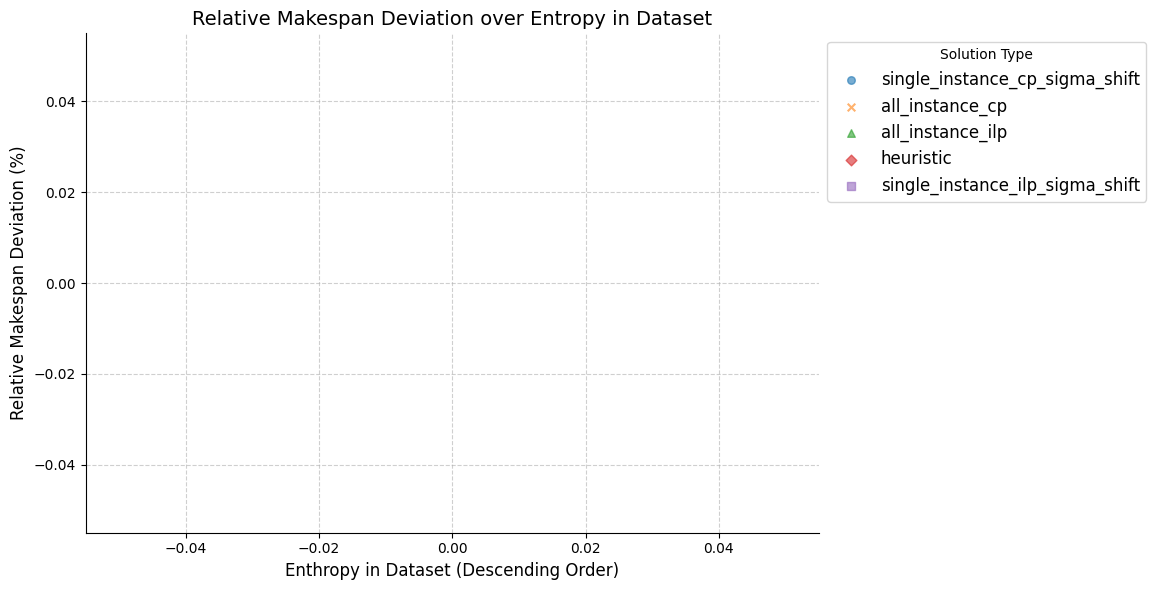

In [42]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)


marker_dict = {
    "all_instance_cp": "x",
    "single_instance_cp_sigma_shift": "o",
    "heuristic": "D",
    "all_instance_ilp": "^",
    "single_instance_ilp_sigma_shift": "s"
}

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
plot =sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    markers=[marker_dict[s] for s in visual_df["solution_type"].unique()],
    scatter_kws={'s': 30, 'alpha': 0.6},  # Customize scatter points
    line_kws={'linewidth': 1.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
)

# Add labels and title
# Remove extra legends
plot._legend.remove()
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation over Entropy in Dataset", fontsize=14)
plt.legend(title="Solution Type", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


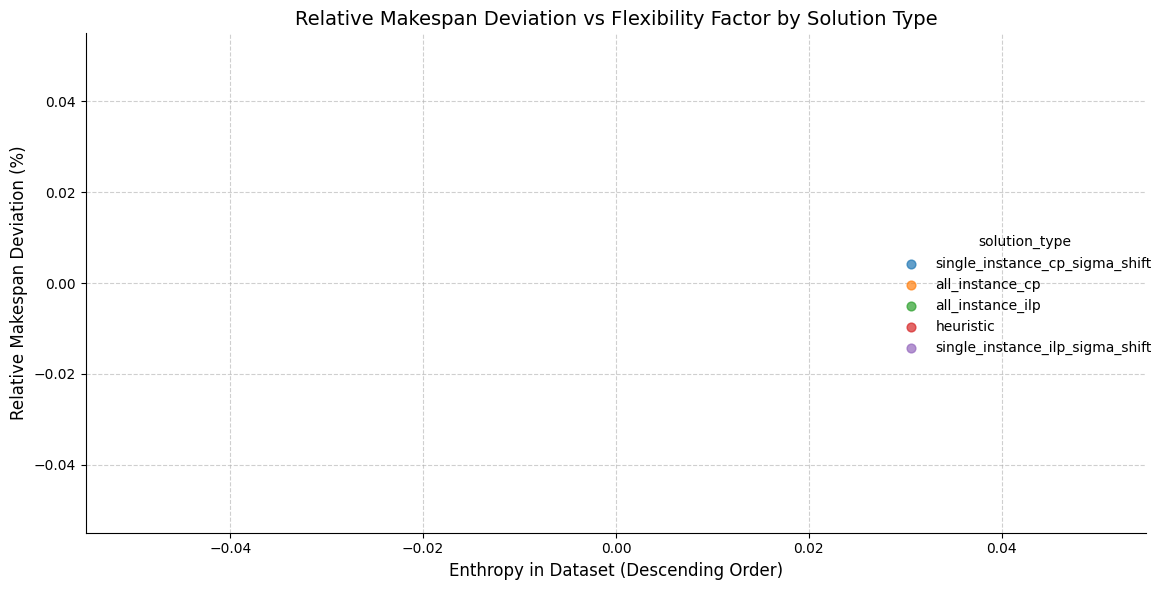

In [43]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 0.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_685795/228415945.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Solution Type")


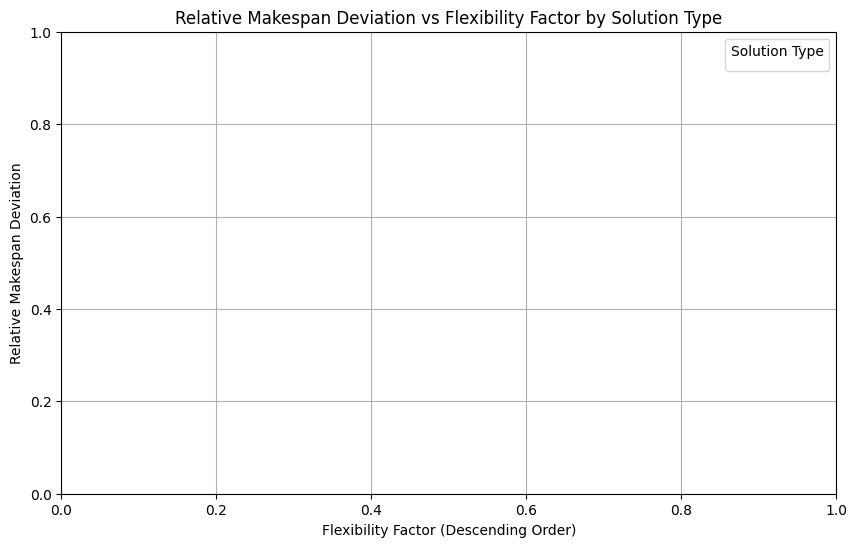

In [44]:
# Sort by flex_factor in descending order
#visual_df
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Create the lineplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    marker="o"
)

# Add labels and title
plt.xlabel("Flexibility Factor (Descending Order)")
plt.ylabel("Relative Makespan Deviation")
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type")
plt.legend(title="Solution Type")
plt.grid(True)
plt.show()

In [45]:
# concatenate eval_df1..4
dfs = [df.rename(columns={df.columns[0]: f"relative_makespan_deviation{suffix}"}) for df, suffix in zip([eval_df0, eval_df1, eval_df2, eval_df3, eval_df4], [suffix0, suffix1, suffix2, suffix3, suffix4])]
result = pd.concat(dfs, axis=1)
result

,relative_makespan_deviation_no_filter,relative_makespan_deviation_only_with_deletes,relative_makespan_deviation_early,relative_makespan_deviation_10_Tasks,relative_makespan_deviation_30_Tasks
solution_type,,,,,
all_instance_cp,0.000,0.000,0.000,0.000,0.000
single_instance_cp_sigma_shift,8.005,7.550,7.460,10.870,6.705
heuristic,14.530,17.015,15.150,24.625,10.920
all_instance_ilp,26.980,26.650,24.355,52.205,14.990
single_instance_ilp_sigma_shift,34.470,33.905,32.820,52.770,25.955


## Checks based on Arrival

In [46]:
objective_df = df[
    (df['release_type'] == 'arrival') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df5 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "differentiated_arrival"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

KeyError: 'config.cp_distribution_str'

In [ ]:
objective_df = df[
    (df['release_type'] == 'same_release') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df6 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix6 = "same_release_Tasks"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,287.111111,35.500000,1.083333,0.266667
single_instance_cp_sigma_shift,311.138889,304.527778,25.111111,9.076389
heuristic,337.944444,NaN,51.916667,21.738333
all_instance_ilp,360.583333,354.638889,74.000000,33.534167
single_instance_ilp_sigma_shift,389.888889,389.888889,103.861111,42.848889


### Extra Checks


In [ ]:

objective_df = df[['set_ident','solution_type', 'objective', 'min_objective']]
# Step 1: Get the min_objective for "all_instance_cp" for each set_ident
min_obj_cp = df[df["solution_type"] == "all_instance_cp"][["set_ident", "solution_type", "objective", "min_objective"]].reset_index()

# Step 2: Merge with the original dataframe to compare min_objective for each set_ident
df_merged = objective_df.join(min_obj_cp, on="set_ident", rsuffix=("_cp"))

# Step 3: Filter rows where the min_objective doesn't match the min_objective for "all_instance_cp"
filtered_df = df_merged[df_merged["min_objective"] != df_merged["objective_cp"]]

filtered_df

,set_ident,solution_type,objective,min_objective,index,set_ident_cp,solution_type_cp,objective_cp,min_objective_cp
index,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_cp,118.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_cp_sigma_shift,132.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_ilp,134.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_ilp_sigma_shift,153.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,heuristic,167.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
...,...,...,...,...,...,...,...,...,...
"testsets_random/30_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",101,all_instance_cp,776.0,776.0,NaN,NaN,NaN,NaN,NaN
"testsets_random/30_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",101,single_instance_cp_sigma_shift,785.0,776.0,NaN,NaN,NaN,NaN,NaN
"testsets_random/30_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",101,heuristic,813.0,776.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
objective_df
df_raw[df_raw['ilp_objective'].notna()][['ilp_objective', 'ilp_runtime']]

,ilp_objective,ilp_runtime
index,,
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000279
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000266
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000297
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000269
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-2-10.json",24.0,0.000263
...,...,...
"testsets_random/30_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-early-normal-2-1-30.json",166.0,0.000271
"testsets_random/30_instantArr/evaluation/all_instance_ilp/(1, 0, 0.0)-skill_short_branch-3-early-normal-3-1-30.json",143.0,0.000341
"testsets_random/30_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-early-normal-3-1-30.json",143.0,0.000339


## Combined Solution

In [ ]:
combined_solution_df

,objective,solver_status,lower_bound,optimality_gap,computing_time
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","[39, 48, 58, 68, 78, 88, 98, 112, 137, 150]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 48, 58, 68, 78, 88, 98, 112, 137, 150]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-3-1-10.json","[31, 40, 51, 62, 73, 84, 95, 106, 117, 128]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[31, 40, 51, 62, 73, 84, 95, 106, 117, 128]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.8, 0.2, 0.0)-skill_short_branch-3-early-resource_based-4-2-10.json","[60, 95, 115, 159, 197, 217, 261, 299, 319, 363]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[60, 95, 115, 159, 197, 217, 261, 299, 319, 363]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.03, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json","[61, 80, 104, 122, 146, 164, 188, 206, 230, 248]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[61, 80, 104, 122, 146, 164, 188, 206, 230, 248]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json","[33, 45, 59, 71, 84, 97, 110, 123, 136, 149]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[33, 45, 59, 71, 84, 97, 110, 123, 136, 149]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.0..."
...,...,...,...,...,...
"testsets_random/20_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-3-2-20.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/20_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-early-normal-2-1-20.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/20_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-early-resource_based-4-1-20.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/20_generated/evaluation/all_instance_cp/(1, 0, 0.0)-random-3-uniform-normal-3-1-20.json",NaN,NaN,NaN,NaN,NaN


## Parallelity Evaluation

In [ ]:
data = load_evaluation_files( root_path = "testsets_spread")
df, combined_solution_df = generate_pandas_df(data)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['spread_arr']
50 datasets loaded


/tmp/ipykernel_685795/575386664.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [ ]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

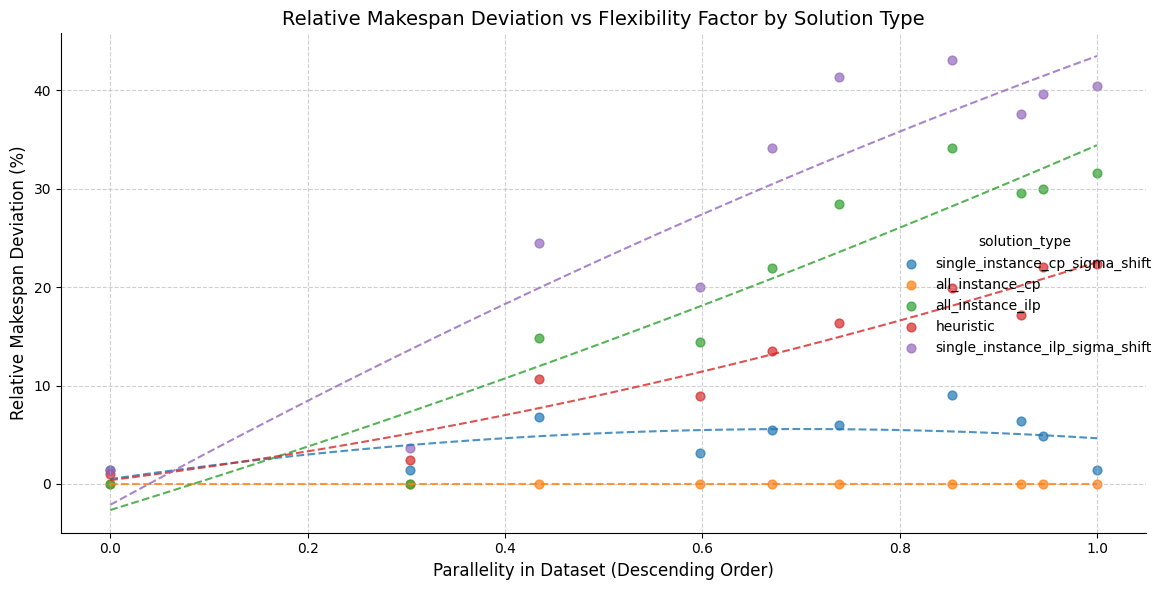

In [ ]:
import numpy as np
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='parallelity_norm', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="parallelity_norm",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
    fit_reg=False
)

# Fit and plot non-linear trendlines
x_range = np.linspace(visual_df["parallelity_norm"].min(), visual_df["parallelity_norm"].max(), 100)

for solution in visual_df["solution_type"].unique():
    subset = visual_df[visual_df["solution_type"] == solution]
    if len(subset) < 3:
        continue  # Skip if not enough points for fitting
    
    # Fit a quadratic (2nd-degree) polynomial regression
    coefficients = np.polyfit(subset["parallelity_norm"], subset["relative_makespan_deviation"], deg=2)
    poly_model = np.poly1d(coefficients)
    
    # Plot the non-linear trendline
    plt.plot(x_range, poly_model(x_range), label=f"{solution} (trend)", linestyle="--", alpha=0.8)

# Add labels and title
plt.xlabel("Parallelity in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Multi Instance Evaluation


In [ ]:
data = load_evaluation_files( root_path = "testsets_random")
df, combined_solution_df = generate_pandas_df(data)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['10_instantArr', '10_generated', '30_instantArr', '30_generated', '20_instantArr', '20_generated']


KeyboardInterrupt: 

In [ ]:
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_cp,118.0,0.0,...,118.0,51.0,Feasible,426.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_cp_sigma_shift,132.0,14.0,...,118.0,132.0,Optimal,416.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_ilp,134.0,16.0,...,118.0,134.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_ilp_sigma_shift,153.0,35.0,...,118.0,153.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,heuristic,167.0,49.0,...,118.0,NaN,NaN,441.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random/30_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",100,1.000000,1.000000,0.991804,0.904411,0.604046,all_instance_cp,776.0,0.0,...,776.0,26.0,Feasible,2509.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",100,1.000000,1.000000,0.991804,0.904411,0.604046,single_instance_cp_sigma_shift,785.0,9.0,...,776.0,741.0,Feasible,2101.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",100,1.000000,1.000000,0.991804,0.904411,0.604046,heuristic,813.0,37.0,...,776.0,NaN,NaN,2269.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
objective_df = df
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

/home/felixs/Programming_Projects/ra_pst_py/venv/lib64/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felixs/Programming_Projects/ra_pst_py/venv/lib64/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felixs/Programming_Projects/ra_pst_py/venv/lib64/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felixs/Programming_Projects/ra_pst_py/venv/lib64/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/felixs/Programming_Projects/ra_pst_py/venv/lib64/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_ilp,79.0,79.0,0.0,0.00,NaN,3.0
single_instance_ilp_sigma_shift,79.0,79.0,0.0,0.00,NaN,3.0
all_instance_cp,211.0,211.0,147.0,83.54,NaN,3.0
heuristic,223.0,NaN,159.0,111.39,NaN,3.0
single_instance_cp_sigma_shift,222.0,222.0,158.0,137.97,NaN,3.0
